# Grounded-SAM-HQ Playground

## Install Requirements

In [12]:
!pip install --upgrade 'supervision>0.14' transformers scipy safetensors 'opencv-python-headless<4.8.0' 'opencv-python<4.8.0' --no-dependencies
# accelerate cause error in transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 72 kB 2.3 MB/s eta 0:00:01
  Attempting uninstall: supervision
    Found existing installation: supervision 0.11.1
    Uninstalling supervision-0.11.1:
      Successfully uninstalled supervision-0.11.1
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install -q git+https://github.com/IDEA-Research/GroundingDINO.git

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4+1.g536eedd6e requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
dvc 3.1.0 requires platformdirs<4,>=3.1.1, but you have platformdirs 4.0.0 which is incompatible.
cudf 23.2.0 requires pandas<1.6.0dev0,>=1.0, but you have pandas 2.0.2 which is incompatible.
cudf 23.2.0 requires protobuf==3.20.3, but you have protobuf 4.23.3 which is incompatible.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [9]:
!mkdir pretrained_checkpoint/
!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_h.pth?download=true -P pretrained_checkpoint/ -O pretrained_checkpoint/sam_hq_vit_h.pth
!wget https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth -O pretrained_checkpoint/groundingdino_swint_ogc.pth
!wget https://raw.githubusercontent.com/IDEA-Research/Grounded-Segment-Anything/main/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py -O pretrained_checkpoint/GroundingDINO_SwinT_OGC.py

mkdir: cannot create directory ‘pretrained_checkpoint/’: File exists
--2023-11-20 15:35:30--  https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_h.pth?download=true
Resolving huggingface.co (huggingface.co)... 3.160.5.76, 3.160.5.109, 3.160.5.25, ...
Connecting to huggingface.co (huggingface.co)|3.160.5.76|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/d9/4e/d94e04992ac4e3ea45fcc1c523974540cdbef274e295d4aaacc69b4f19ee63b7/a7ac14a085326d9fa6199c8c698c4f0e7280afdbb974d2c4660ec60877b45e35?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sam_hq_vit_h.pth%3B+filename%3D%22sam_hq_vit_h.pth%22%3B&Expires=1700753730&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwMDc1MzczMH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9kOS80ZS9kOTRlMDQ5OTJhYzRlM2VhNDVmY2MxYzUyMzk3NDU0MGNkYmVmMjc0ZTI5NWQ0YWFhY2M2OWI0ZjE5ZWU2M2I3L2E3YWMxNGEwODUzMjZkOWZhNj

## Initialize Modules

In [32]:
import torch
import json
import os
import cv2
import numpy as np
from tqdm.notebook import tqdm
import supervision as sv

from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.amg import (
    mask_to_rle_pytorch
)

# Grounding DINO
import groundingdino.datasets.transforms as T
from groundingdino.util.inference import load_image, Model

SAM_ENCODER_VERSION = "vit_h"
SAM_CHECKPOINT_PATH = "./pretrained_checkpoint/sam_hq_vit_h.pth"
FINETUNED_MASKED_CHECKPOINT_PATH = "./train/work_dirs/hq_sam_h/epoch_4.pth"
GDINO_CKPT_PATH = "pretrained_checkpoint/groundingdino_swint_ogc.pth"
GDINO_CONFIG_PATH = "pretrained_checkpoint/GroundingDINO_SwinT_OGC.py"

finetune = True

device = torch.device("cpu")
if torch.cuda.is_available():
   device = torch.device("cuda:0")

if finetune:
    sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH)
    sam.mask_decoder.load_state_dict(torch.load(FINETUNED_MASKED_CHECKPOINT_PATH))
else:
    sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH)

sam.to(device=device)
sam_predictor = SamPredictor(sam)

grounding_dino_model = Model(
    model_config_path=GDINO_CONFIG_PATH,
    model_checkpoint_path=GDINO_CKPT_PATH,
    device = "cuda",
)

<All keys matched successfully>
final text_encoder_type: bert-base-uncased


## Local Hoarder Dataset

In [2]:
from hoarder.datasets.local_dataset import LocalDataset

ld = LocalDataset(path='sample_data/TestSAM')
ld_frames = ld.get_frames()

In [3]:
from hoarder.utils.conservator_utils import get_label_sets, get_label_id_from_name

label_sets = get_label_sets()
label_name2ids = {}
for label in label_sets:
    if label.name == "LifeguardSegment":
        label_name2ids = {l.name:l.id for l in label.labels}

label_ids2idx = {id:idx for idx, id in enumerate(list(label_name2ids.values()))}

### SAM-HQ Segmentation Pipeline

In [33]:
sample_index = 10

frame_info = ld_frames[sample_index]
image_path = ld.get_local_image_path(frame_info)

image_np = cv2.imread(image_path)
image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
image_shape = image_np.shape
sam_predictor.set_image(image_np)

annotations = frame_info['annotations']
generated_metadata = {
    "boxes": [],
    "masks": [],
    "class_id": [],
}
for idx, ann in enumerate(annotations):
    if "boundingBox" in ann:
        box = ann["boundingBox"]
        x = int(box["x"])
        y = int(box["y"])
        w = int(box["w"])
        h = int(box["h"])

        label = ann["labels"][0]
        if label not in list(label_name2ids.keys()):
            continue

        input_box = torch.tensor([[x, y, x+w, y+h]], device=device)
        transformed_box = sam_predictor.transform.apply_boxes_torch(input_box, image_shape[:2])
        masks, _, _ = sam_predictor.predict_torch(
            point_coords=None,
            point_labels=None,
            boxes=transformed_box,
            multimask_output=False,
            hq_token_only=False,
        )
        masks = masks.squeeze().detach().cpu().numpy() # [H,W]
        generated_metadata["boxes"].append([x, y, x+w, y+h])
        generated_metadata["masks"].append(masks)
        generated_metadata["class_id"].append(label_ids2idx[label_name2ids[label]])

detections = sv.Detections(
    xyxy=np.array(generated_metadata["boxes"]),
    mask=np.array(generated_metadata["masks"]),
    class_id=np.array(generated_metadata["class_id"])
)

#### Display Polygons

In [8]:
assert sv.__version__ == '0.16.0'
polygon_annotator = sv.PolygonAnnotator()
annotated_frame = polygon_annotator.annotate(scene=image_np.copy(), detections=detections)
sv.plot_image(annotated_frame)

AttributeError: module 'supervision.annotators.core' has no attribute 'PolygonAnnotator'

#### Displaying Mask

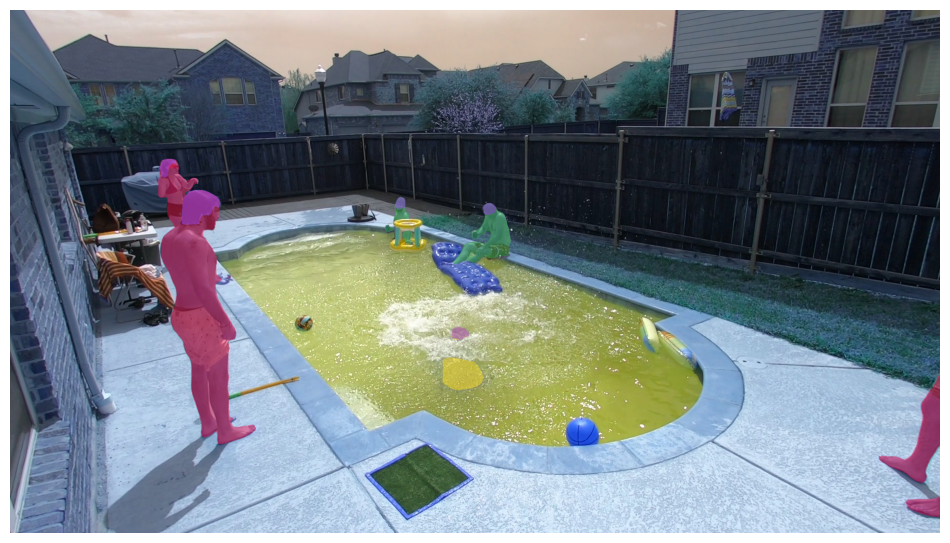

In [34]:
mask_annotator = sv.MaskAnnotator()
annotated_frame = mask_annotator.annotate(scene=image_np.copy(), detections=detections)
sv.plot_image(annotated_frame)

#### Displaying Boxes

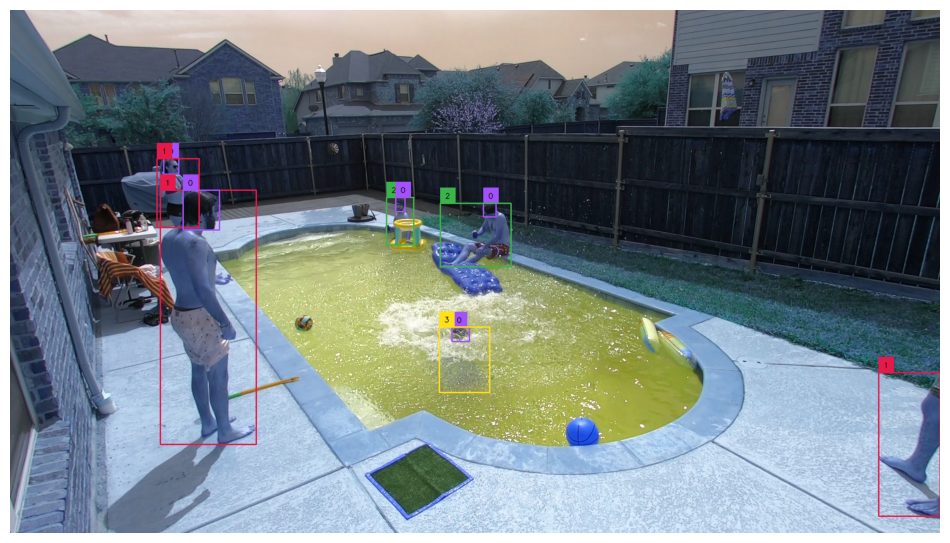

In [35]:
box_annotator = sv.BoxAnnotator()
annotated_frame = box_annotator.annotate(scene=image_np.copy(), detections=detections)
sv.plot_image(annotated_frame)

### Grounded-SAM-HQ Detection Pipeline

#### Generate Boxes from Grounding Dino

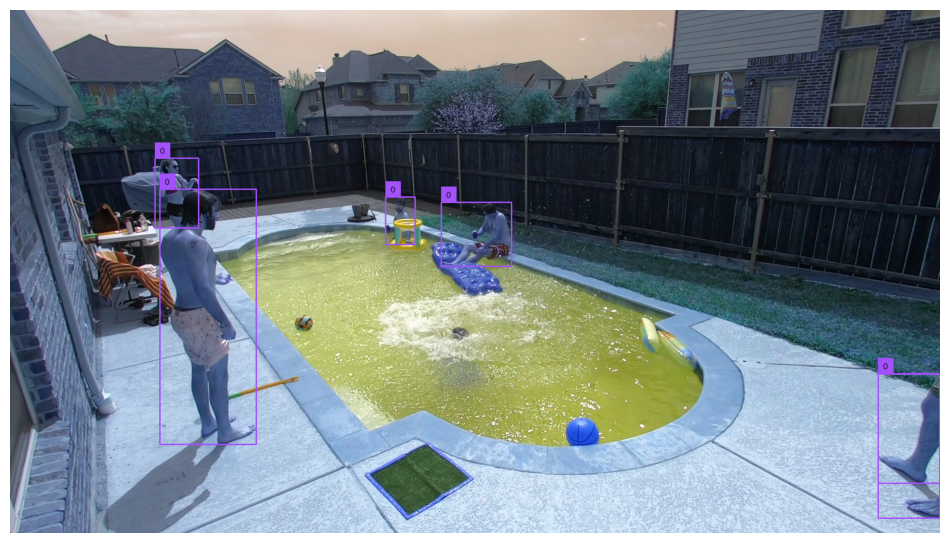

In [16]:
from PIL import Image

TEXT_PROMPT = "person"
BOX_THRESHOLD = 0.245
TEXT_THRESHOLD = 0.287

# load image
sam_predictor.set_image(image_np)

# detect objects
detections, phrases = grounding_dino_model.predict_with_caption(
    image=image_np,
    caption=TEXT_PROMPT,
    box_threshold=BOX_THRESHOLD,
    text_threshold=BOX_THRESHOLD
)
class_id = Model.phrases2classes(phrases=phrases, classes=[TEXT_PROMPT])
detections.class_id = class_id

box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
annotated_image = box_annotator.annotate(scene=image_np.copy(), detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=[TEXT_PROMPT])

sv.plot_image(annotated_image)

#### Generate Masks from Grounding Dino

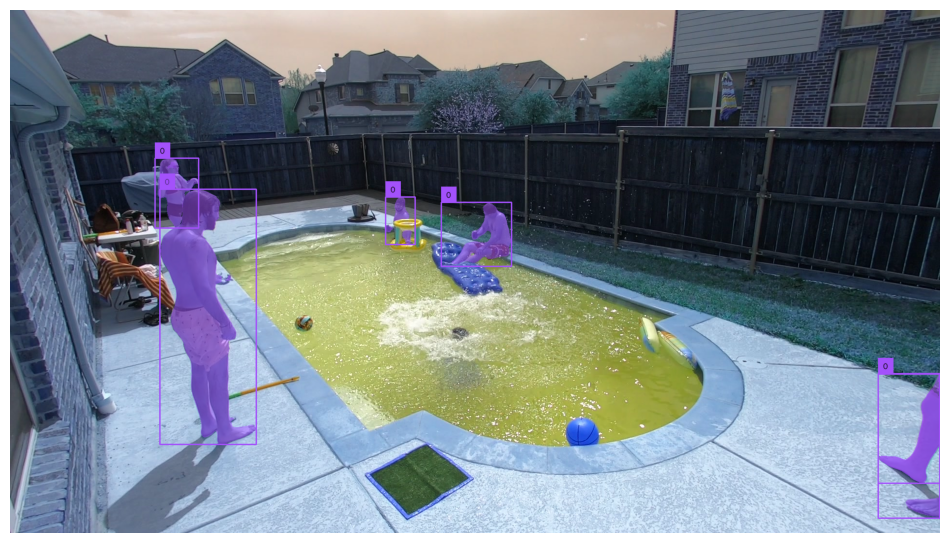

In [17]:
# box: normalized box xywh -> unnormalized xyxy
import torch

boxes_xyxy = torch.Tensor(detections.xyxy)
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_np.shape[:2]).to(device)
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
        )

mask_annotator = sv.MaskAnnotator()

if isinstance(masks, torch.Tensor):
    masks = masks.cpu().numpy().squeeze(1)
detections.mask = masks

annotated_image = mask_annotator.annotate(scene=annotated_image, detections=detections)
sv.plot_image(annotated_image)